# Ensembles

Training multiple models and combining their outputs has some advantages over training a single model:

* [Wisdom of the Crowds](https://en.wikipedia.org/wiki/The_Wisdom_of_Crowds): combining the guesses of many may be as or more accurate than one expert,
* an ensemble of "weak" models, meaning ones that are not as accurate as they could be, can result in a better result than one "strong" model,
* weak models can be made by using less-complex models, such as fewer layers or units in a neural network,
* weak models can also be made by training each model on subsets of the training data, making models that can fit on a GPU and also leads to more diverse models.

In [1]:
import numpy as np

import torch
print(torch.__version__)

import time

import gzip
import pickle

import matplotlib.pyplot as plt

2.1.0


In [2]:
from convnet2d import ConvNet2D  # from Lecture Notes 21

Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet2D(input_shape=(1, 28, 28), 
                     conv_specs=[(20, 4, 1), (10, 3, 2)],
                     fc_specs=[20],
                     n_outputs = 10,
                     device='cpu')               
```
`conv_specs` has a sublist for each convolutional layer, specifying `(n_units, kernel_size, stride)`.

In [3]:
import socket

if torch.cuda.is_available():
    print(f'{socket.gethostname()} has an available cuda GPU.')
    
if torch.backends.mps.is_available():
    print(f'{socket.gethostname()} has an available mps GPU.')
    
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# device = 'cpu'

print('Using device', device)

samuel has an available cuda GPU.
Using device cuda


In [4]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1] 
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1] 

In [5]:
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

In [6]:
input_shape = (1, 28, 28)
n_outputs = 10

n_epochs = 10
batch_size = 5000

In [7]:
n_nnets = 20
nnets = []

for i in range(n_nnets):
    print(f'Training nnet {i+1} out of {n_nnets} ...', end='')
    nnet = ConvNet2D(input_shape, 
                     [], #(20, 4, 1)], # , (10, 3, 2)], 
                     [], 
                     n_epochs, 'tanh', device)
    use_these = np.random.choice(np.arange(Xtrain.shape[0]), batch_size, replace=False)
    nnet.train(Xtrain[use_these], Ttrain[use_these], Xval, Tval, 
               n_epochs, method='adam', learning_rate=0.001, verbose=False)
    print(f' % correct: Train {nnet.pc_trace[-1][0]:.1f} Val {nnet.pc_trace[-1][1]:.1f}')
    
    nnets.append(nnet)


Training nnet 1 out of 20 ...ConvNet: Using device cuda
 % correct: Train 64.0 Val 66.5
Training nnet 2 out of 20 ...ConvNet: Using device cuda
 % correct: Train 64.5 Val 66.6
Training nnet 3 out of 20 ...ConvNet: Using device cuda
 % correct: Train 60.4 Val 61.9
Training nnet 4 out of 20 ...ConvNet: Using device cuda
 % correct: Train 65.1 Val 68.2
Training nnet 5 out of 20 ...ConvNet: Using device cuda
 % correct: Train 60.7 Val 63.5
Training nnet 6 out of 20 ...ConvNet: Using device cuda
 % correct: Train 60.9 Val 62.8
Training nnet 7 out of 20 ...ConvNet: Using device cuda
 % correct: Train 64.4 Val 66.4
Training nnet 8 out of 20 ...ConvNet: Using device cuda
 % correct: Train 61.0 Val 63.3
Training nnet 9 out of 20 ...ConvNet: Using device cuda
 % correct: Train 61.9 Val 64.4
Training nnet 10 out of 20 ...ConvNet: Using device cuda
 % correct: Train 65.6 Val 66.2
Training nnet 11 out of 20 ...ConvNet: Using device cuda
 % correct: Train 66.9 Val 68.4
Training nnet 12 out of 20 ...

In [8]:
all_outputs = [nnet.use(Xtest) for nnet in nnets]
all_outputs = np.array(all_outputs)
all_outputs = all_outputs.T
all_outputs.shape

(10000, 20)

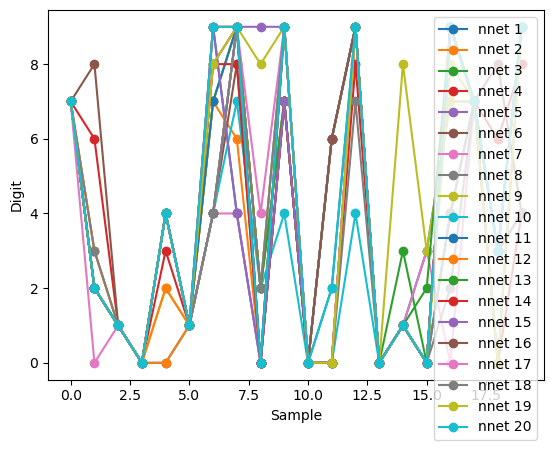

In [9]:
plt.plot(all_outputs[:20, :], 'o-')
plt.xlabel('Sample')
plt.ylabel('Digit')
plt.legend([f'nnet {i+1}' for i in range(all_outputs.shape[0])]);

In [10]:
uniques, counts = np.unique(all_outputs, axis=-1, return_counts=True)

In [11]:
uniques.shape, counts.shape

((10000, 20), (20,))

In [12]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
Y = all_outputs[:3, :]
Y

array([[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [2, 3, 2, 6, 2, 8, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 3, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [14]:
np.bincount(Y[0])

array([ 0,  0,  0,  0,  0,  0,  0, 20])

In [15]:
np.bincount(Y[0]).argmax()

7

In [16]:
def most_common(values):
    return np.bincount(values).argmax()

In [17]:
most_common(Y[0])

7

In [18]:
most_common(Y[1])

2

In [19]:
np.apply_along_axis(most_common, axis=-1, arr=Y)

array([7, 2, 1])

In [20]:
Y_most_common = np.apply_along_axis(most_common, axis=-1, arr=all_outputs)
Y_most_common

array([7, 2, 1, ..., 9, 8, 6])

In [21]:
Y_most_common.shape

(10000,)

In [22]:
for i in range(len(nnets)):
    nnet = nnets[i]
    Y = all_outputs[:, i]
    pc = nnet.percent_correct(Y, Ttest)
    print(f'nnet {i} {pc:.2f} % correct')
    
pc_all = nnets[0].percent_correct(Y_most_common, Ttest)
print(f'\nensemble {pc_all:.2f} % correct')

nnet 0 65.41 % correct
nnet 1 64.50 % correct
nnet 2 61.23 % correct
nnet 3 65.92 % correct
nnet 4 62.37 % correct
nnet 5 61.01 % correct
nnet 6 63.85 % correct
nnet 7 62.57 % correct
nnet 8 62.73 % correct
nnet 9 65.14 % correct
nnet 10 66.59 % correct
nnet 11 64.16 % correct
nnet 12 63.48 % correct
nnet 13 64.04 % correct
nnet 14 62.34 % correct
nnet 15 63.28 % correct
nnet 16 63.48 % correct
nnet 17 66.64 % correct
nnet 18 65.66 % correct
nnet 19 61.58 % correct

ensemble 71.27 % correct


There are other ways of combining the outputs of the ensemble models:

* pick the most common classification across the models for each sample;
* average the class probabilities across the models, then pick the max;
* weight average of the class probabilities, weighted by how accurate each model is over the validation set. 